## 准备工作

### 引入各类库

In [1]:
### 引入所有包
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from fake_useragent import UserAgent
import json
import time
import random
from urllib.parse import quote
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from PIL import Image,ImageEnhance
import hashlib
from collections import Counter
from gensim import corpora, models, similarities
import codecs, sys
import os
import codecs
import shutil
import jieba
from pyhanlp import *
import jpype
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import feature_extraction  
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.feature_extraction.text import CountVectorizer
from pdfminer.converter import PDFPageAggregator
from pdfminer.layout import LAParams
from pdfminer.pdfparser import PDFParser, PDFDocument
from pdfminer.pdfdevice import PDFDevice
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter

### 将所有pdf文本，转化为表格

In [4]:
### pdf转化器
def pdfreader(filename):
    """
    将pdf转化为text文本
    Param filename:文档名
    return final_test:最终文本内容列表
    """
    try:
        #获得文档对象,以二进制读方式打开
        fp = open(filename, "rb")

        #创建一个与文档关联的分析器
        parser = PDFParser(fp)

        #创建一个pdf文档的对象
        doc = PDFDocument()

        #连接解释器与文档对象
        parser.set_document(doc)
        doc.set_parser(parser)

        #初始化文档,如果文档有密码，写与此。
        doc.initialize("")

        #创建pdf资源管理器
        resource = PDFResourceManager()

        #参数分析器
        laparam = LAParams()

        #创建聚合器
        device = PDFPageAggregator(resource, laparams=laparam)

        #创建pdf页面解释器
        interpreter = PDFPageInterpreter(resource, device)

        #使用文档对象得到页面的集合
        list_text,corpus = [],[]
        for page in doc.get_pages():
            #使用页面解释器读取
            interpreter.process_page(page)
            #使用聚合器来获得内容
            layout = device.get_result()
            for out in layout:
                if hasattr(out, "get_text"):
                    line = out.get_text().strip("\n ")
                    line_clean = re.sub("\n","",line)
                    list_text.append(line_clean)
        final_test = "".join([i for i in list_text if i != ""])
        return final_test
    except Exception as e:
        pass

In [6]:
### 第一部分控制
# os.chdir("正当防卫的1000份文书")
file_list = os.listdir()
corpus = list(map(pdfreader,file_list))

### 文本清理，提取出所有的重要信息

In [8]:
### 文本清理器1
def clean(corpus_none_n):
    """
    param corpus_none_n:不含none的文本列表
    return table_caipanwenshu
    """
    ## 正则表达式部分开始 --------------------------------------------------------------------
    results = corpus_none_n
    ### 原告中的三类可能
    pattern_plaintiff = re.compile(r"原告：([\u4e00-\u9fa5].*?)，") # 原告第一类可能
    pattern_plaintiff_2 = re.compile(r"原告：([\u4e00-\u9fa5].*?)。") # 原告第二类可能
    pattern_plaintiff_3 = re.compile(r"原告.*?，") # 原告第三类可能

    ### 被告中的三类可能
    pattern_defender = re.compile(r"被告：.*?，")
    pattern_defender_2 = re.compile(r"被告：.*?。")

    ### 原告出生年龄
    pattern_plaintiff_birthday = re.compile(r"原告：.*\d.*?出生，")

    ### 被告出生年龄
    pattern_defender_birthday = re.compile(r"被告：.*\d.*?出生，")

    ### 立案时间
    pattern_starttime = re.compile(r"，本院于.*\d.立案后，")

    ### 诉讼请求
    pattern_claims = re.compile(r"诉讼请求：.*?。")
    pattern_claims_2 = re.compile(r"诉称，.*本院认为")

    ### 事实和理由
    pattern_facts = re.compile(r"事实和理由：.*。")

    ### 辩护事实
    pattern_defence = re.compile(r"辩称：.*")
    pattern_defence_2 = re.compile(r"辩称，.*")

    ### 法院认定事实
    pattern_court_fact_1 = re.compile(r"认定事实如下：.*。本院")
    pattern_court_fact_2 = re.compile(r"经审理查明：.*。本院")
    pattern_court_fact_3 = re.compile(r"经审理查明，.*。本院")

    ### 法院对事实的判定
    pattern_court_advise = re.compile(r"本院认为.*")

    ### 法院的意见
    pattern_court_attitude = re.compile(r"综上所述.*?。")

    ### 法条
    pattern_laws_1 = re.compile(r"《.*?》.*?条")
    pattern_laws_2 = re.compile(r"《.*?》.*?条，")
    pattern_laws_3 = re.compile(r"(《.*?[^》]*条)")
    pattern_laws_4 = re.compile(r"《.*?》")

    ### 判决
    pattern_judgement = re.compile("判决如下:.*。") #需要使用去掉\n的文档
    
    ## 正则表达式部分结束 --------------------------------------------------------------------
    ## 搜索原告
    def find_plaintiffs(text,pattern1,pattern2,pattern3):
        if re.search(pattern1,text):
            piece = re.search(pattern1,text).group().strip(":原告：，")
            return piece
        elif re.search(pattern2,text):
            piece = re.search(pattern2,text).group().strip(":原告：，")
            return piece
        elif re.search(pattern3,text):
            piece = re.search(pattern3,text).group().strip(":原告：，")
            return piece
        else:
            return None

    ## 搜索被告
    def find_defender(text,pattern1,pattern2):
        if re.search(pattern1,text):
            piece = re.search(pattern1,text).group().strip("被告：")
            return piece
        elif re.search(pattern2,text):
            piece = re.search(pattern2,text).group().strip("被告：")
            return piece
        else:
            return None

    ## 搜索原告出生年龄
    def find_plaintiffs_birthday(text,pattern):
        if re.search(pattern,text):
            piece = re.search(pattern,text).group().strip("，")
            text = re.sub("原告：.*，","",piece).strip("出生")
            return text
        else:
            return None

    ## 搜索被告出生年龄
    def find_defenders_birthday(text,pattern):
        if re.search(pattern,text):
            piece = re.search(pattern,text).group().strip("，")
            text = re.sub("被告：.*，","",piece).strip("出生")
            return text
        else:
            return None

    ## 立案时间
    def find_starttime(text,pattern):
        if re.search(pattern,text):
            piece = re.search(pattern,text).group().lstrip("，本院于").rstrip("立案后，")
            return piece
        else:
            return None

    ## 事实和理由
    def find_facts(text,pattern):
        if re.search(pattern,text):
            piece = re.search(pattern,text).group()
            return piece
        else:
            return None

    ## 被告辩称
    def find_defenders_words(text,pattern1,pattern2):
        if re.search(pattern1,text):
            piece = re.search(pattern1,text).group()
            return piece
        elif re.search(pattern2,text):
            piece = re.search(pattern2,text).group()
            return piece
        else:
            return None

    ## 法院认定事实
    def find_court_facts(text,pattern1,pattern2,pattern3):
        if re.search(pattern1,text):
            piece = re.search(pattern1,text).group().rstrip("本院")
            return piece
        elif re.search(pattern2,text):
            piece = re.search(pattern2,text).group().rstrip("本院")
            return piece
        elif re.search(pattern3,text):
            piece = re.search(pattern3,text).group().rstrip("本院")
            return piece
        else:
            return None

    ## 查找法条
    def find_laws(text,pattern3,pattern4):
        if re.search(pattern3,text):
            pieces_1 = re.findall(pattern3,text)
            short_pieces_1 = list(filter(lambda x:len(x) < 50,pieces_1))
            pieces_2 = re.findall(pattern4,text)
            short_pieces_2 = list(filter(lambda x:len(x) < 50,pieces_2))
            short_pieces_3 = short_pieces_1 + short_pieces_2
            return (short_pieces_1,short_pieces_2)
        else:
            return None

    ## 大块文字专用
    def find_claims_or_blocks(text,pattern):
        if re.search(pattern,text):
            piece = re.search(pattern,text).group()
            return piece
        else:
            return None
    
    ## 原告诉求
    def find_claims(text,pattern1,pattern2):
        if re.search(pattern1,text):
            piece = re.search(pattern1,text).group()
            return piece
        elif re.search(pattern2,text):
            piece = re.search(pattern2,text).group()
            return piece
        
    ## 重复pattern，构造pattern list
    def repeat_pattern(pattern):
        pattern_lists = len(list(results)) * [pattern]
        return pattern_lists

    list_piece_t,list_corpus = [],[] 
    ### 是否这里可以改成(**kwargs)
    ### 原告
    
    plaintiffs = list(map(find_plaintiffs,corpus_none_n,repeat_pattern(pattern_plaintiff),
                          repeat_pattern(pattern_plaintiff_2),repeat_pattern(pattern_plaintiff_3)))

    ### 被告
    defenders = list(map(find_defender,corpus_none_n,repeat_pattern(pattern_defender),
                        repeat_pattern(pattern_defender_2)))
    
    ### 原告出生年龄
    plaintiffs_birthday = list(map(find_plaintiffs_birthday,corpus_none_n,repeat_pattern(pattern_plaintiff_birthday)))

    ###被告出生年龄
    defenders_birthday = list(map(find_defenders_birthday,corpus_none_n,repeat_pattern(pattern_defender_birthday)))

    ### 立案时间
    starttimes = list(map(find_starttime,corpus_none_n,repeat_pattern(pattern_starttime)))

    ### 诉讼请求
    claims = list(map(find_claims,corpus_none_n,repeat_pattern(pattern_claims),repeat_pattern(pattern_claims_2)))

    ### 事实与理由
    facts = list(map(find_claims_or_blocks,corpus_none_n,repeat_pattern(pattern_facts)))

    ### 被告辩称
    defences = list(map(find_defender,corpus_none_n,repeat_pattern(pattern_defence),
                        repeat_pattern(pattern_defence_2)))
    
    ### 法院认定事实
    court_facts = list(map(find_court_facts,corpus_none_n,repeat_pattern(pattern_court_fact_1),
                          repeat_pattern(pattern_court_fact_2),repeat_pattern(pattern_court_fact_3)))

    ### 法院对事实的判定
    advises = list(map(find_claims_or_blocks,corpus_none_n,repeat_pattern(pattern_court_advise)))

    ### 法院的态度
    attitudes = list(map(find_claims_or_blocks,corpus_none_n,repeat_pattern(pattern_court_attitude)))

    ### 判决
    judgement = list(map(find_claims_or_blocks,corpus_none_n,repeat_pattern(pattern_judgement)))

    ### 法条
    laws1 = list(map(find_laws,corpus_none_n,repeat_pattern(pattern_laws_3),
                        repeat_pattern(pattern_laws_4)))
    table_caipanwenshu = pd.DataFrame([plaintiffs,defenders,plaintiffs_birthday,defenders_birthday,
                                   starttimes,claims,facts,defences,court_facts,advises,attitudes,judgement,laws1]).T
    table_caipanwenshu.columns = ["原告","被告","原告出生时间","被告出生时间","立案时间","原告诉讼请求",
                              "原告事实与理由","被告辩称","法院认定事实","法院认为","法院意见","法院判决","法条1"]
    return table_caipanwenshu

### 文本清理，剔除掉为空值的单位

In [9]:
### 文本清理器2
def drop_none_columns(table):
    """
    param table:接上面产生的总table
    return final_table:将大多数空值都清洗掉的table
    """
    index_exist,index_none = 0,0
    list_keep = []
    for column in list(table.columns):
        for item in table[column]:
            if item != None:
                index_exist += 1
            else:
                index_none += 1
        ratio = float(index_none) / (float(index_exist) + 1.0) # 剃掉很多都是None的行
        if ratio<= 10:
            list_keep.append(table[column])
        else:
            pass
        index_exist = 0
        index_none = 0
    return pd.DataFrame(list_keep).T

In [12]:
# 第二部分控制
corpus_n_none = list(filter(lambda x:x != None,corpus))
table = clean(corpus_n_none)
table_final_1 = table.drop(["被告","原告出生时间","被告出生时间","立案时间","原告诉讼请求","原告事实与理由"],axis = 1)
table_final_2 = drop_none_columns(table_final_1)
table_final_2

,原告,被告辩称,法院认定事实,法院认为,法院意见,法院判决,法条1
0,）:杨宝,辩称，对一审判决不满意，但没有上诉，不同意张金路的上诉请求。张金路从始至终没有说过一句实话，...,None,本院认为，根据《中华人民共和国侵权责任法》第六条和第十六条的规定可知，行为人因过错侵害他人民...,综上所述，张金路的上诉请求不能成立，应予驳回；一审判决认定事实清楚，适用法律正确，应予维持。,判决如下:驳回上诉，维持原判。二审案件受理费50元，由张金路负担（已交纳）。本判决为终审判决。,"([《中华人民共和国侵权责任法》第六条第一款、第十六条、第二十六条, 《中华人民共和国民事诉..."
1,）何某,None,None,本院认为，2003年10月17日，密云法院作出（2003）密行初字第11号行政判决，该判决在...,综上所述，何某的再审申请超过法定申请再审的期限，依照《最高人民法院关于适用&lt;中华人民共...,None,"([《最高人民法院关于适用&lt;中华人民共和国行政诉讼法&gt;的解释》第一百一十条, 《..."
2,人李某,None,None,本院认为，被告人夏天虎无视国家法律，故意伤害他人身体健康，致一人轻伤，其行为已触犯刑律，构成...,None,判决如下:一、被告人夏天虎犯故意伤害罪，判处有期徒刑十个月，缓刑一年。第 4 页夏天虎故意伤...,"([《人损解释》第十七条, 《最高人民法院关于适用的解释》第一百三十八条、第一百五十五条, ..."
3,None,None,None,本院认为，上诉人张海峰与原审被告人吴过无视国家法律和社会公德，伙同他人在公共场所持械聚众斗殴...,None,None,"([《中华人民共和国刑事诉讼法》第二百二十五条], [《中华人民共和国刑法》, 《中华人民共..."
4,"）:高德珍,女,1970年5月27出生汉族",None,None,本院认为，本案当事人因未能正确处理相邻关系产生矛盾，导致上诉人聂巧连与被上诉人高德珍发生吵打...,综上所述，上诉人聂巧连的上诉请求不能成立，应予驳回。,判决如下:驳回上诉，维持原判。第 3 页聂巧连、高德珍生命权、健康权、身体权纠纷二审民事判决...,"([《最高人民法院关于适用的解释》第九十条, 《中华人民共和国侵权责任法》第六条第一款、第十..."
5,None,None,经审理查明，2015年11月3日凌晨2时许，被告人周卫祥从景谷县”浅水湾KTV”出来至门口时...,本院认为，上诉人周卫祥故意伤害他人身体致轻伤二级，其行为已构成故意伤害罪，应予以刑罚处罚。原...,None,None,"([《中华人民共和国刑法》第二百三十四条第一款、第六十五条、第六十七条第三款、第四十七条, ..."
6,人李某,辩称，其没有殴打过被害人，案发时不在现场，不应承担民事赔偿责任。 经审理查明...,经审理查明，2017年4月10日下午17时许，李某因怀疑自家畜圈的垃圾是被告人李正成家的人故...,本院认为，被告人李正成与被害人李某是同村村民，双方系邻里关系，被害人李某因怀疑李正成家人扔垃...,None,判决如下:一、被告人李正成犯故意伤害罪，判处有期徒刑一年，缓刑二年（缓刑考验期自判决执行之日...,"([《中华人民共和国刑法》第二百三十四条, 《中华人民共和国刑法》第二百三十四条第一款、第六..."
7,人邹某1,None,None,本院认为，被告人胡某3与自诉人邹某1系翁婿关系，在平时的生产、生活中理应和睦相处，但双方因琐...,None,判决如下:一、被告人胡某3犯故意伤害罪，判处有期徒刑一年，缓刑一年零六个月。（缓刑考验期限自...,"([《中华人民共和国侵权责任法》第六条、第二十六条, 《最高人民法院关于适用《中华人民共和国..."
8,人）字某,None,None,本院认为，原审被告人李小强无视国家法律，故意伤害他人身体，其行为已经构成故意伤害罪，且致人死...,None,None,"([《关于适用的解释》第一百五十五条, 《中华人民共和国刑事诉讼法》第二百三十七条, 《最高..."
9,None,None,None,None,None,None,None


## 文本分析

In [ ]:
# 词频抽取
## 原始文本 -> Stopwords后分词 --> 原始关键词词频 完成
## 原始文本 -> TextRank关键词提取 --> 关键词抽取 完成  
## 原始文本 -> 词性识别 -> 名词抽出 完成
## 原始文本 -> TextRank摘要抽取 完成
## 原始文本 -> 人名识别 完成
## 原始文本 -> 名词共现 -> 语义网络分析 完成

# 短语提取
## 原始文本 -> 根据关键词推荐文书 完成
## 法院认为 -> 搜索"正当防卫"，并且re -->得到含有关键词的表述 -- > 人工识别 完成
## 法院认为 -> 基于互信息和左右信息熵的短语提取 完成

# 词袋模型&分类
## 法院判决 -> 使用stopwords筛一遍后 -> TF-IDF变词袋 -> 文档相似度计算 --> 推荐相似的判决 （HanLP可解决）完成
## 法院判决 -> 使用stopwords筛一遍后 -> LDA分类 --> 查看分类情况 # 完成
## 法院判决 -> 使用stopwords筛一遍后 -> Kmeans文本聚类 --> 查看聚类情况 完成
### 法院判决 -> 使用stopwords筛一遍后 -> 循环神经网络 --> 查看分类情况 此步需要有很多次分类与训练，人工标注集

## 初始标准分词 范例
## HanLP.segment其实是对StandardTokenizer.segment的封装。
## print(HanLP.segment('你好，欢迎在Python中调用HanLP的API'))
## for term in HanLP.segment("你好，欢迎在Python中调用HanLP的API"):
## print('{}\t{}'.format(term.word, term.nature))

## NLP分词 范例
## NLPTokenizer = JClass("com.hankcs.hanlp.tokenizer.NLPTokenizer")
## print(NLPTokenizer.segment("我新造一个词叫幻想乡你能识别并正确标注词性吗？")) 
## find_all_chinesename(table_final_2["原告"])
## table_test_3 

### 引入临时文档和上步存储到的表

In [39]:
import pickle
import os
#os.chdir("正当防卫的1000份文书")
with open("corpus.pickle", 'rb') as f:
    corpus = pickle.load(f)
table_final_2 = pd.read_excel("final_table_2.xlsx")
table_final_3 = pd.read_excel("夫妻债务2018.01.18-2019.03.15.xlsx")

In [40]:
table_final_3.head()["法院意见"]
table_final_3.head()["判决结果"]

0    依照《最高人民法院关于审理涉及夫妻债务纠纷案件适用法律有关问题的解释》第三条、《中华人民共和...
1    依照《中华人民共和国民事诉讼法》第一百四十四条、第二百条第（六）项、第（九）项、第二百零七条...
2    依照最高人民法院《关于审理涉及夫妻债务纠纷案件适用法律有关问题的解释》第三条、《中华人民共和...
3                                                  NaN
4    依照《中华人民共和国民事诉讼法》第一百七十条第一款第（二）项、《最高人民法院关于适用《中华人...
Name: 判决结果, dtype: object

### 文书筛选前验工具

In [41]:
### 按照关键词来筛选
### 如夫妻共同债务部分，判断依据为两个
pattern_basic = re.compile(r"夫妻共同")
pattern_basic_2 = re.compile(r"共同债务")

list_alpha = []
def basic_mapping(elem,pattern1):
    try:
        if re.search(pattern1,elem):
            return True
        else:
            return False
    except Exception as e:
        return False

def basic_mapping_2(elem,pattern1,pattern2):
    try:
        if re.search(pattern1,elem):
            return True
        elif re.search(pattern2,elem):
            return True
        else:
            return False
    except Exception as e:
        return False    
    
### results = list(map(basic_mapping_2,court_judgements,[pattern_basic] * len(court_judgements),[pattern_basic_2] * len(court_judgements)))
### doc2vec聚类
### 由于中文分词效果很一般，方法待检验
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import jieba

def data_prepare():
    data = list(table_final_3["法院意见"][0:20].dropna())
    tagged_data = [TaggedDocument(words=jieba.lcut(_d), tags=[str(i)]) for i, _d in enumerate(data)]

def train_model():
    max_epochs = 100
    vec_size = 20
    alpha = 0.025

    model = Doc2Vec(size=vec_size,
                    alpha=alpha, 
                    min_alpha=0.00025,
                    min_count=1,
                    dm =1)

    model.build_vocab(tagged_data)

    for epoch in range(max_epochs):
        #print('iteration {0}'.format(epoch))
        model.train(tagged_data,
                    total_examples=model.corpus_count,
                    epochs=model.iter)
        # decrease the learning rate
        model.alpha -= 0.0002
        # fix the learning rate, no decay
        model.min_alpha = model.alpha

    model.save("d2v.model")
    
def find_similarities():
    model = Doc2Vec.load("d2v.model")
    similar_doc = model.docvecs.most_similar(2,topn=10)
    return similar_doc

find_similarities()

[('1', 0.7040582895278931),
 ('10', 0.532119631767273),
 ('6', 0.5193359851837158),
 ('0', 0.49194127321243286),
 ('3', 0.4698929786682129),
 ('5', 0.44459882378578186),
 ('16', 0.41593512892723083),
 ('13', 0.4133766293525696),
 ('14', 0.4081152677536011),
 ('15', 0.40067481994628906)]

In [43]:
### 如果给到的是表格
### 法条抽取
pattern_laws_1 = re.compile(r"《.*?》.*?条")
pattern_laws_2 = re.compile(r"《.*?》.*?条，")
pattern_laws_3 = re.compile(r"(《.*?[^》]*条)")
pattern_laws_4 = re.compile(r"《.*?》")

def repeat_pattern(pattern,results):
    pattern_lists = len(list(results)) * [pattern]
    return pattern_lists

def find_laws(text,pattern3,pattern4):
    if re.search(pattern3,text):
        pieces_1 = re.findall(pattern3,text)
        short_pieces_1 = list(filter(lambda x:len(x) < 50,pieces_1))
        pieces_2 = re.findall(pattern4,text)
        short_pieces_2 = list(filter(lambda x:len(x) < 50,pieces_2))
        short_pieces_3 = short_pieces_1 + short_pieces_2
        return (short_pieces_1,short_pieces_2)
    else:
        return None

#find_laws(test[3],pattern_laws_3,pattern_laws_4)
test = table_final_3["判决结果"].dropna()
laws = list(map(find_laws,test,repeat_pattern(pattern_laws_3,test),
repeat_pattern(pattern_laws_4,test)))
table = pd.DataFrame([laws]).T

### 法条统计

In [44]:
# 法条统计
laws = list(filter(lambda x:isinstance(x,tuple),table[0]))
laws_item_1,laws_item_2,list_temp_3 = [],[],[]

def generate_all_laws_1(laws):
    for item1,item2 in laws:
        for item in item1:
            laws_item_1.append(item)
    return laws_item_1

def generate_all_laws_2(laws):
    for item1,item2 in laws:
        for item in item2:
            laws_item_2.append(item)
    return laws_item_2

def split_all_laws(laws_item):
    for item in laws_item:     
        if "&lt;" in item:
            item = re.sub("&lt;","",item)
            item = re.sub("&gt;","",item)
        try:
            # 如果法条前面没有《..法》，就得识别并且用循环加
            list_temp,list_temp_2 = [],[]
            law_name = re.search("《.*?》",item).group()
            item_list = item.split("、")
            for item in item_list:
                if "《" not in item:
                    list_temp.append(law_name + item)
            item_list.extend(list_temp)

            # 提取前面有《..法》的法条
            for law in item_list:
                if "《" in law:
                    list_temp_2.append(law)
            list_temp_3.append(list_temp_2)
        except Exception as e:
            list_temp_3.append("[]")
    return list_temp_3

def count_laws_2(list_temp_3):
    law_corpus = []
    for law_list in list_temp_3:
        for item in law_list:
            law_corpus.append(item)
    return law_corpus

laws_item = generate_all_laws_1(laws)
list_temp_3 = split_all_laws(laws_item)
law_corpus = count_laws_2(list_temp_3)
table_final = pd.DataFrame([dict(Counter(law_corpus))]).T.sort_values(0,ascending = False)

single_law = generate_all_laws_2(laws)
table_single_laws = pd.DataFrame([dict(Counter(single_law))]).T.sort_values(0,ascending = False)

In [48]:
table_final.head()

,0
《中华人民共和国民事诉讼法》第二百零七条,498
《中华人民共和国民事诉讼法》第一百七十条,492
《中华人民共和国民事诉讼法》第二百五十三条,483
《中华人民共和国民事诉讼法》第二百零七条第一款,284
《中华人民共和国民事诉讼法》第一百四十四条,236


In [6]:
## 法条统计
def count_laws(table):
    """
    param table:含有法条数据的列表
    return table_laws_ascending:含有法条数据的结果
    """
    list_fatiao_corpus = []
    fatiao2d = list(table["法条"])
    for case in fatiao2d:
        if not isinstance(case,float):
            case_unrepeated = list(set(eval(case)))
            for law in case_unrepeated:
                list_fatiao_corpus.append(law)
    table_laws = pd.DataFrame([dict(Counter(list_fatiao_corpus))]).T
    table_laws.columns = ["数量"]
    table_laws_ascending = table_laws.sort_values("数量",ascending = False)
    return table_laws_ascending
#count_laws(table_final_2).head()

### 罪名统计（刑事）

In [49]:
def find_keywords_in_courts_v3(li):
    list_key_expressions = []
    pattern_sentences = re.compile("([^。]*犯.*?罪[^。]*)。")
    for item in li:
        try:
            facts = re.findall(pattern_sentences,item)
            list_key_expressions.append(facts)
        except Exception as e:
            facts = None
            list_key_expressions.append(None)
    return list_key_expressions

final_result_names = []
pattern_limitation = re.compile("(犯.*?罪)")
list_key_expressions = find_keywords_in_courts_v3(table_final_2["法院判决"])
list_key_expression_filter_1 = list(filter(lambda x:x != None,list_key_expressions))
list_key_expression_filter_2 = list(filter(lambda x:x != [],list_key_expression_filter_1))
for sentences in list_key_expression_filter_2:
    for sentence in sentences:
        final_result = re.search(pattern_limitation,sentence).group()
        if final_result != "犯罪":
            if len(final_result) <= 10:
                final_result_names.append(final_result)
crimes_table = pd.DataFrame([final_result_names,[1] * (len(final_result_names))]).T
crimes_table.groupby(0).count().sort_values(by = 1,ascending = False)

,1
0,
犯故意伤害罪,335
犯前款罪,61
犯聚众斗殴罪,20
犯寻衅滋事罪,7
犯故意毁坏财物罪,4
犯有数罪,4
犯故意杀人罪,3
犯数罪,3
犯过失致人重伤罪,3


### 绝对词频统计

In [50]:
# -*- coding:utf-8 -*-
# 绝对词频统计
from pyhanlp import *
import jpype

pattern_word = re.compile(r".*?\\")
pattern_nature = re.compile(r"\\.*")

list_useful_words,list_natures = [],[]
def segments(article,stopwords):
    """
    param article:每篇文章
    param stopwords:停用词列表
    return list_articles:每篇文章的分词
    """
    for item in HanLP.segment(article):
        try:
            item_word = ('{}\{}'.format(item.word, item.nature))
            word = re.search(pattern_word,item_word).group()
            nature = re.search(pattern_nature,item_word).group()
            word_clean = word.strip("\\")
            nature_clean = nature.strip("\\")
            if word_clean not in list_stopwords:
                list_useful_words.append(word_clean)
                list_natures.append(nature_clean)
        except Exception as e:
            pass
    return list_useful_words,list_natures

def DF(list_useful_words,list_natures):
    """
    param list_useful_words:清洗后得到的词表
    param list_natures:清洗后词性的词性表
    return table_test_3:
    """
    table_test = pd.DataFrame([list_useful_words,list_natures]).T
    table_test.columns = ["word","nature"]
    
    ### 只提取名词和动词！！！！！！！！
    table_test_2 = table_test[table_test["nature"].isin(["n","v"])]
    table_test_3 = table_test_2.groupby("word").count().sort_values(["nature"],ascending = ["False"])
    return table_test_3

def main_word_freqs(corpus,list_stopwords):
    """
    param corpus:每个的文本
    param list_stopwords:
    return list_articles:每篇关键词的频率
    """
    list_articles = []
    for article in corpus[0:10]:
        try:
            list_useful_words,list_natures = segments(article,list_stopwords)
            table = DF(list_useful_words,list_natures)
            list_articles.append(table)
        except Exception as e:
            pass
    return list_articles

In [51]:
### 第三部分控制
### 懒得写__main__()了
list_stopwords = []
with open("stopwords.txt","r",encoding = "utf-8") as f:
    for word in f.readlines():
        list_stopwords.append(word.strip("\n"))

corpus = list(filter(lambda x:x!=None,corpus))
list_articles = main_word_freqs(corpus,list_stopwords)
pd.concat(list_articles).groupby("word").sum().sort_values("nature",ascending = False).head()
# list_articles[0].sort_values("nature",ascending = "F")[::-1]
# pd.concat(list_articles).groupby("word").sum().sort_values("nature",ascending = False)

,nature
word,
被告人,720
证据,579
本院,558
法律,340
虎,328


### 关键词抽取

In [52]:
## -*- coding:utf-8 -*-
## 关键词提取
from pyhanlp import *
import jpype

list_keywords = []
TextRankKeyword = JClass("com.hankcs.hanlp.summary.TextRankKeyword")
def segments_keywords(article):
    keywords = list(HanLP.extractKeyword(article,10))
    list_keywords.append(keywords)
    
for article in corpus[0:5]:
    keywords_extraction = segments_keywords(article)

In [55]:
list_keywords

[['张金路', '杨宝', '广顺', '尹', '证据', '判决', '提供', '证明', '主张', '进行'],
 ['何某', '判决', '再审', '原审', '池某', '申请人', '申请', '证人', '密云', '北京市'],
 ['夏天', '虎', '被告人', '原告人', '本院', '李某', '证据', '中', '被害人', '附带'],
 ['张海峰', '被告人', '上诉人', '吴过', '原审', '聚众斗殴', '证据', '行为', '审理', '法律'],
 ['原告', '高德', '珍', '上诉人', '被告', '被上诉人', '聂巧连', '判决', '事实', '本院']]

### 文本摘要抽取

In [56]:
## 摘要
from pyhanlp import *
import jpype

TextRankSentence = JClass("com.hankcs.hanlp.summary.TextRankSentence")
corpus = list(filter(lambda x:x!=None,corpus))
list_summary = []
def summary(article):
    sentence_list = list(HanLP.extractSummary(article,10))
    list_summary.append(sentence_list)
    
for article in corpus[0:5]:
    summ = summary(article)

In [57]:
list_summary

[['因张金路未提供证据证明杨宝对其进行殴打',
  '第一、尹广顺、刘久如、杨宝三人以张金路欠三人工资为理由',
  '证明张金路将杨宝打伤',
  '一、张金路于判决生效后七日内赔偿杨宝医疗费、误工费、交通费共计1969元',
  '张金路将杨宝打伤',
  '故对杨宝要求张金路给付劳务费的诉讼请求不予支持',
  '尹广顺、杨宝、刘久如三人在现场对张金路及其母亲进行了言语上的辱骂',
  '张金路在纠纷过程中将杨宝打伤',
  '证明该判决书中法院认定张山与杨宝是雇佣关系',
  '杨宝、尹广顺阻拦其二人离开'],
 ['何某等与北京市公安局密云分局再审审查与审判监督行政裁定书 - OpenLaw.CN 开放法律联盟何某等与北京市公安局密云分局再审审查与审判监督行政裁定书北京市第三中级人民法院裁定书(2018)京03行申10号再审申请人（原审原告）何某',
  '申请人何某申请再审称',
  '何某的再审申请超过法定申请再审的期限',
  '（二）原判决、裁定认定事实的主要证据是伪造的',
  '且申请人提交的证人证言不属于足以推翻原审判决的新证据',
  '未认定何某的行为属正当防卫',
  '驳回何某的再审申请',
  '应当在判决、裁定或者调解书发生法律效力后六个月内提出',
  '本案申请人申请再审的时间已远超判决生效后的六个月期限',
  '密云法院的判决将池某片面认定为受害人'],
 ['二、由被告人夏天虎赔偿附带民事诉讼原告人李某的各项损失共计人民币37',
  '附带民事诉讼原告人李某要求被告人夏天虎赔偿其医疗费402.77元、鉴定费2800元、后期医疗费59',
  '本院对原告人李某有证据证明且符合法律规定的医疗费402.77元、伤情、伤残及后期医疗鉴定费共计2100元予以确认',
  '本院将据此对被告人夏天虎酌情从轻处罚',
  '本院对原告人李某提交的证据及其诉讼请求评判如下',
  '对被告人夏天虎辩护人提出的夏天虎在本案中系正当防卫的辩护意见',
  '夏天虎用石块砸伤被害人李某的行为依法不能认定为系制止不法侵害的正当防卫',
  '依法应当认定被告人夏天虎在本案中构成自首',
  '本院依法确认原告人李某在本案中所产生的损失为',
  '依法可以减轻被告人夏天虎的民事赔偿责任'],
 ['一审判决认定被告人吴过、张海峰犯聚众斗殴

### 根据关键词推荐文书

In [58]:
# -*- coding:utf-8 -*-
## 根据关键词推荐文书
Suggester = JClass("com.hankcs.hanlp.suggest.Suggester")
suggester = Suggester()
for article in corpus[0:5]:
    suggester.addSentence(article)
    
list(suggester.suggest("赔偿",1))[0][0:100]

'夏天虎故意伤害一审刑事判决书 - OpenLaw.CN 开放法律联盟夏天虎故意伤害一审刑事判决书昆明市官渡区人民法院判决书（2017）云0111刑初996号公诉机关昆明市官渡区人民检察院。附带民事诉讼'

In [60]:
# -*- coding:utf-8 -*-
## 根据关键词推荐结果
Suggester = JClass("com.hankcs.hanlp.suggest.Suggester")
suggester = Suggester()
results = list(filter(lambda x:isinstance(x,str),table_final_2["法院判决"]))

for article in results[0:5]:
    suggester.addSentence(article)

list_suggestions = list(suggester.suggest("驳回",100))
list_suggestions

['判决如下:驳回上诉，维持原判。二审案件受理费50元，由张金路负担（已交纳）。本判决为终审判决。',
 '判决如下:驳回上诉，维持原判。第 3 页聂巧连、高德珍生命权、健康权、身体权纠纷二审民事判决书 - OpenLaw.CN 开放法律联盟二审案件受理费，免收。本判决为终审判决。',
 '判决如下:一、被告人李正成犯故意伤害罪，判处有期徒刑一年，缓刑二年（缓刑考验期自判决执行之日起计算）；二、附带民事诉讼原告人李某的经济损失76271.7元，由被告人李正成赔偿61017.4元，扣除已支付的20000元，还应赔偿41017.4元，款限本判决生效后三十日内付清；三、驳回附带民事诉讼原告人李某的其他诉讼请求。如不服本判决，可在接到判决书的第二日起十日内，通过本院或者直接向楚雄彝族自治州中级人民法院提出上诉。书面上诉的，应提交上诉状正本一份，副本二份。',
 '判决如下:一、被告人胡某3犯故意伤害罪，判处有期徒刑一年，缓刑一年零六个月。（缓刑考验期限自判决确定之日起计算。二、由被告人胡某3赔偿自诉人邹某1医疗、误工、护理、住院伙食补助、营养、鉴定、交通、后续治疗、平车使用等费，合计76836.54元的70%，即53786元，扣除已支付的15000元，还应支付38786元。（限判决生效后30日内付清。三、驳回自诉人邹某1的其他诉讼请求。如不服本判决，可在接到判决书的第二日起十日内，通过本院或者直接向大理白族自治州中级人民法院提出上诉。书面上诉的，应交上诉状正本一份，副本三份。',
 '判决如下:一、被告人夏天虎犯故意伤害罪，判处有期徒刑十个月，缓刑一年。第 4 页夏天虎故意伤害一审刑事判决书 - OpenLaw.CN 开放法律联盟（缓刑考验期自判决确定之日起计算）。二、由被告人夏天虎赔偿附带民事诉讼原告人李某的各项损失共计人民币37,661.94元，须于判决生效后十日内一次性付清。三、驳回附带民事诉讼原告人李某的其他诉讼请求。如不服本判决，可在接到判决书的第二日起十日内通过本院或者直接向云南省昆明市中级人民法院提出上诉。书面上诉的，应当提交上诉状正本一份，副本一份。']

### 提取文本中实体短语

In [64]:
# -*- coding:utf-8 -*-
## 提取短语
"""
for text in results[0:10]:
    phrase_list = HanLP.extractPhrase(text,5)
    print(text)
    print(phrase_list)
"""
def find_keywords_in_courts_v1(li):
    list_key_expressions = []
    pattern_sentences = re.compile("([^。]*正当防卫[^。]*)。")
    for item in li:
        try:
            facts = re.findall(pattern_sentences,item)
            list_key_expressions.append(facts)
        except Exception as e:
            facts = None
            list_key_expressions.append(None)
    return list_key_expressions

results_clean = list(map(lambda x:x.strip("判决如下:"),results))
a1 = find_keywords_in_courts_v1(results_clean)
a2 = find_keywords_in_courts_v2(results_clean)
a3 = find_keywords_in_courts_v3(results_clean)

for item in list(map(lambda x:"".join(x),a2)):
    phrase_list = HanLP.extractPhrase(item,5)
    print(phrase_list)

[]
[判处有期徒刑, 有期徒刑月, 犯故意伤害罪, 虎犯, 被告人虎]
[]
[之日起计算, 判决执行, 判决生效, 判处有期徒刑, 原告人李某]
[判处有期徒刑, 犯故意伤害罪, 缓刑月, 胡某犯, 被告人胡某]
[]
[判处有期徒刑, 张春良犯, 有期徒刑月, 犯故意伤害罪, 被告人张春良]
[宣告缓刑, 不良影响宣告, 犯故意伤害罪, 重大不良影响, 附加刑仍须]
[判处有期徒刑, 有期徒刑被告人, 犯故意伤害罪, 王玉成犯, 王铁柱犯]
[不满怀孕, 事实犯罪, 以下有期徒刑, 再犯罪, 决定刑罚]
[判处有期徒刑, 天河犯, 犯故意伤害罪, 被告人天河]
[]
[]
[]
[]
[]
[]
[上诉人莫耀领, 人民法院刑, 刑初, 初附带, 判处拘役]
[]
[判处有期徒刑, 吴某犯, 有期徒刑月, 犯故意伤害罪, 被告人吴某]
[依法给予, 判处有期徒刑, 判处赔偿, 十六条犯罪行为, 处罚外]
[]
[决定执行, 判处有期徒刑, 执行有期徒刑, 挪用资金罪, 有期徒刑月]
[之日起计算, 刑期判决, 判决执行, 判处有期徒刑, 执行之日起]
[世界犯, 之日起计算, 判决确定, 判处有期徒刑, 月缓刑]
[]
[]
[余聪犯, 刘睿犯, 判处有期徒刑, 有期徒刑月, 犯故意伤害罪]
[判处有期徒刑, 寻衅滋事罪, 徐某某犯, 有期徒刑被告人, 杜某某犯]
[]
[]
[之日起计算, 判决确定, 判处拘役, 叶水清犯, 拘役月]
[宣告缓刑, 判处拘役, 不良影响宣告, 故意伤害判决书, 文礼新故意伤害]
[]
[宣告缓刑, 判处拘役, 不良影响宣告, 犯故意伤害罪, 肖悦容犯]
[]
[宣告缓刑, 不良影响宣告, 犯故意伤害罪, 被告人黄伟, 重大不良影响]
[]
[不同情况, 主管部门予以, 予以行政处罚, 予以训诫, 免予处罚]
[人民检察院人民法院, 人民法院提出, 从宽处罚, 作出起诉, 判处拘役]
[判处有期徒刑, 宪法犯, 有期徒刑月, 朱宪法, 犯故意伤害罪]
[判处有期徒刑, 景某某犯, 有期徒刑月, 犯故意伤害罪, 被告人景某某]
[判处管制, 张某某犯, 犯故意伤害罪, 被告人张某某]
[判处有期徒刑, 有期徒刑月, 朱成农犯, 犯故意伤害罪, 被告人朱成农]
[不满怀孕, 以下有期徒刑, 再犯罪, 判处拘役, 妇女满]
[]
[之

[判处有期徒刑, 开放法律, 张某甲犯, 故意伤害判决书, 有期徒刑月]
[判处有期徒刑, 有期徒刑月, 犯故意伤害罪, 被告人陈熙, 陈熙犯]
[]
[]
[令狐荣犯, 判处有期徒刑, 犯故意伤害罪, 被告人令狐荣]
[判处有期徒刑, 四化犯, 有期徒刑月, 犯故意伤害罪, 被告人四化]
[判处有期徒刑, 犯故意伤害罪, 王贵彪犯, 被告人王贵彪]
[犯聚众斗殴, 原审被告人, 刑事判决主文, 初刑事判决, 吴倩犯]
[]
[]
[上诉人原审, 予以没收, 人民法院刑, 作案工具斧头, 依法予以]
[之日起计算, 刑期判决, 判决执行, 判处有期徒刑, 执行之日起]
[]


In [ ]:
results_clean[0:100]

### 词语共现、语义网络

In [65]:
## -*- coding:utf-8 -*-
## 词语共现模块

## 将第一步所得到的词频表合并 
table_topwords = pd.concat(list_articles).groupby("word").sum().sort_values("nature",ascending = False)

## 重命名表头
table_topwords["词语"] = table_topwords.index
table_topwords.index = range(len(table_topwords))
table_topwords.columns = ["频率","词语"]

## 共现第一步，找每篇文章里存在多少词
def find_word_in_articles(corpus,word_table):
    """
    word_table:高频词列表，此处设定为：table_topwords["词语"]
    corpus:文档文集，此处设定为：corpus[0:10],只取前十个做范例
    """
    list_vector = []
    list_matrix = []
    for item in word_table:
        for word_list in [sentence for sentence in corpus]:
            if item in str(word_list):
                list_vector.append(1)
            else:
                list_vector.append(0)
        list_matrix.append(list_vector)
        list_vector = []
    return list_matrix
    
## 共现第二步，找词语共现情况
def find_coappear(word1,word2):
    """
    Params:
    word_table:高频词列表，此处设定为：table_topwords["词语"]
    corpus:文档文集，此处设定为：corpus[0:10],只取前十个做范例
    """
    coappear = 0
    for item in zip(table_matrix.T[word1],table_matrix.T[word2]):
        if item == (1,1):
            coappear += 1
    list_vector.append(coappear)
    list_matrix.append(list_vector)

list_matrix_pre = find_word_in_articles(corpus,table_topwords["词语"])
table_matrix = pd.DataFrame(list_matrix_pre)
table_matrix.index = table_topwords["词语"]
print(table_matrix.head())

list_vector = []
list_matrix = []    
table_matrix = table_matrix[0:100]
for word1 in table_matrix.index:
    list_vector = []
    for word2 in table_matrix.index:
        find_coappear(word1,word2)

     0    1    2    3    4    5    6    7    8    9   ...   962  963  964  \
词语                                                    ...                   
被告人    0    0    1    1    0    1    1    1    1    0 ...     0    0    1   
证据     1    1    1    1    1    1    1    1    1    0 ...     1    0    1   
本院     1    1    1    1    1    1    1    1    1    0 ...     1    0    1   
法律     1    1    1    1    1    1    1    1    1    1 ...     1    1    1   
虎      0    0    1    0    0    0    0    0    0    0 ...     0    0    0   

     965  966  967  968  969  970  971  
词语                                      
被告人    1    1    1    1    1    0    0  
证据     1    1    1    1    1    1    1  
本院     1    1    1    1    1    1    1  
法律     1    1    1    1    1    1    1  
虎      0    0    0    0    0    0    0  

[5 rows x 972 columns]


In [67]:
## -*- coding:utf-8 -*-
## 共现第三步，发现最大共现
table_coappear = pd.DataFrame(list_matrix)[0::100]
table_coappear.index = table_topwords[0:100]["词语"]
table_coappear.columns = table_topwords[0:100]["词语"]
table_coappear["词语"] = table_coappear.index

table_co = table_coappear
table_co.index = table_co["词语"]
list_save_tuple = []
for item in table_co.index:
    for index,value in zip(table_co[item].index,table_co[item]):
        list_save_tuple.append((item,index,value))
table_co2 = pd.DataFrame(list_save_tuple)
table_co2.columns = ["word1","word2","weight"]
list_unrepeated = []
for i,j,q in zip(table_co2["word1"],table_co2["word2"],table_co2["weight"]):
    if i != j:
        list_unrepeated.append((i,j,q))
table_unrepeated = pd.DataFrame(list_unrepeated)
table_unrepeated.columns = ["word1","word2","weight"]
table_unrepeated_s = table_unrepeated.sort_values("weight",ascending = False)
table_unrepeated_s

## 第四步，扔到gephi里，进一步发现语义网络图谱
table_unrepeated_s.head()

,word1,word2,weight
367,法律,书,971
7045,书,开放,971
1587,开放,法律,971
312,法律,开放,971
7032,书,法律,971


In [68]:
table_coappear["正当防卫"].sort_values(ascending = False).head()

词语
开放      878
书       878
正当防卫    878
月       878
本院      878
Name: 正当防卫, dtype: int64

### 查询含有关键词的上下文和句子（重要工具）

In [73]:
# -*- coding:utf-8 -*-
## 查询含有关键词的上下文
import re

# 正当防卫查询
def find_keywords_in_courts_v1(li):
    list_key_expressions = []
    pattern_sentences = re.compile("([^。]*正当防卫[^。]*)。")
    for item in li:
        try:
            facts = re.findall(pattern_sentences,item)
            list_key_expressions.append(facts)
        except Exception as e:
            facts = None
            list_key_expressions.append(None)
    return list_key_expressions

# 判处查询
def find_keywords_in_courts_v2(li):
    list_key_expressions = []
    pattern_sentences = re.compile("([^。]*判处[^。]*)。")
    for item in li:
        try:
            facts = re.findall(pattern_sentences,item)
            list_key_expressions.append(facts)
        except Exception as e:
            facts = None
            list_key_expressions.append(None)
    return list_key_expressions

def clean_1(elem):
    if elem == []:
        elem.append("None")
    if elem == None:
        elem = ["None"]
    return elem

list_key_expressions = find_keywords_in_courts_v1(table_final_2["法院认为"])
list_key_expressions

[['张金路在上诉意见中主张其系正当防卫，故不应对杨宝的损失承担赔偿责任，但张金路就其主张未能充分举证，故本院不予采纳'],
 [],
 ['对被告人夏天虎辩护人提出的夏天虎在本案中系正当防卫的辩护意见，本院认为，正当防卫是指为了使国家、公共利益、本人或者他人的人身、财产和其他权利免受正在进行的不法侵害，而采取的制止不法侵害的行为，对不法侵害人造成损害的，属于正当防卫，不负刑事责任',
  '据此，本院认为，被害人持刀走向被告人夏天虎的行为不能认定为正在进行的不法侵害，被告人夏天虎的合法权益在案发当时并未处于现实、紧迫的侵害威胁，没有实施正当防卫的紧迫性，夏天虎用石块砸伤被害人李某的行为依法不能认定为系制止不法侵害的正当防卫，故对辩护人的该辩护意见不予采纳'],
 ['本案系双方结伙相互进行打斗，在冲突中，张海峰一方首先持械，该行为激化了斗殴双方的情绪，诱发矛盾升级，上诉人张海峰的行为不符合正当防卫的法律条件，故其正当防卫的上诉理由及辩护人所提辩护意见与审理查明事实不符，且与法律规定相悖，本院不予采纳'],
 ['上诉人聂巧连认为，其行为属正当防卫的上诉理由，与本案查明的事实不符，无证据证实其行为属正当防卫，故上诉人认为其行为属正当防卫的上诉理由不能成立'],
 ['原判根据上诉人周卫祥在案件中的犯罪事实、犯罪情节、认罪和悔罪态度等，对其作出罪责刑相适应的判决并无不妥，定罪量刑均属适当，故上诉人周卫祥及其辩护人提出上诉人周卫祥的行为具有正当防卫性质及自首情节，且被害人亦有一定过错，请求对其适用缓刑的上诉理由及辩护意见无证据证实，亦与庭审查明的事实不符，本院不予采纳'],
 ['辩护人提出被告人李正成有自首情节，可从轻处罚的辩护意见，符合法律规定，本院予以采纳；提出被告人是因为被害人先拿出刀向其挥舞，自己害怕才打伤被害人李某的，故李正成的行为属于正当防卫，不应负刑事责任的辩护意见，本院审查后认为本案无证据证实被害人用刀对被告人李正成挥舞的事实，李正成的行为不属于正当防卫，故此辩护意见，本院不予采纳'],
 ['第 4 页胡某3故意伤害罪一审刑事判决书 - OpenLaw.CN 开放法律联盟关于胡某3及辩护暨诉讼代理人提出邹某1持镰刀追砍胡某3，胡某3出于防卫随手拿起一把小锤无意中打伤邹某1的行为构成正当防卫的辩护意见',
  '本院认为，正当防卫是指为了使国家、公共利

### 中文人名识别

In [70]:
## 中文人名识别
def find_all_chinesename(li):
    names_extract = []
    segment = HanLP.newSegment().enableNameRecognize(True)
    for sentence in li:
        try:
            term_list = segment.seg(sentence)
            for item in term_list:
                if "/nr" in str(item):
                    names_extract.append(str(item).strip("/nr"))
                elif "/nz" in str(item):
                    names_extract.append(str(item).strip("/nz"))
                else:
                    names_extract.append(None)
        except Exception as e:
            pass
    return names_extract 

names_extract = find_all_chinesename(corpus)
names_extract_clean = list(filter(lambda x:x!= None,names_extract))
print(names_extract_clean)

['张金路', '杨宝', '张金路', '杨宝', '上诉人', '张金路', '被上诉人', '杨宝', '上诉人', '张金路', '被上诉人', '杨宝', '健康权', '民事判决', '张金路', '杨宝', '诉讼请求', '杨宝', '张金路', '石淑云', '尹', '广顺', '尹', '广顺', '杨宝和', '刘久如', '金路', '尹', '广顺', '杨宝', '刘久如', '张金路', '张金路', '尹', '广顺', '尹', '广顺', '张金路', '尹', '广顺', '刘久如', '杨宝', '张金路', '尹', '广顺', '金路', '民事行为', '金路', '违法行为', '尹', '广顺', '尹', '广顺', '尹', '广顺', '张金路', '张金路', '张金路', '张金路', '杨宝', '杨宝', '杨宝', '刘久如', '杨宝', '张金路', '张山', '杨宝', '刘久如', '尹', '广顺', '尹', '广顺', '张金路', '杨宝', '张金路', '刘', '张金路', '金路', '张金路', '张金路', '张金路', '杨宝', '张金路', '尹', '广顺', '张金路', '大兴庄', '尹', '广顺', '违法行为', '没想到', '尹', '广顺', '张金路', '杨宝', '张金路', '张金路', '法庭上', '张金路', '杨宝', '尹', '广顺', '尹', '广顺', '张金路', '张山处', '欠薪', '杨宝', '杨宝', '杨宝', '低声下气', '杨宝', '张金路', '杨宝', '诉讼请求', '杨宝', '王辛庄', '询问笔录', '张金路', '杨宝', '张金路', '张金路', '尹', '广顺', '杨宝', '张金路', '王辛庄', '询问笔录', '杨宝', '杨宝', '张金路', '杨宝', '张金路', '张金路', '杨宝', '杨宝', '金路', '张金路', '杨宝', '证明力', '张金路', '张山', '张金路', '杨宝', '杨宝', '张金路', '张金路', '张山', '杨宝', '张山', '张金路', '杨宝', '杨宝', '法律效力', '张山', '张金路'

### 地名识别&实体机构名识别

In [71]:
segment_organization = HanLP.newSegment().enableOrganizationRecognize(True)
segment_place = HanLP.newSegment().enablePlaceRecognize(True)

def find_specific_word(segment_method,corpus,limitation):
    """
    搜索机构名/地名
    param segment_method:查询地名，还是机构名
    param corpus:查询怎样的文本
    param limitation:限定词词性
    """
    for sentence in corpus:
        term_list = segment_method.seg(sentence)
        for every_word in term_list:
            if limitation in str(every_word):
                if "之日起" not in str(every_word):
                    print(str(every_word).strip("/nt/ns"))
                    
results = list(filter(lambda x:isinstance(x,str),table_final_2["法院判决"]))
find_specific_word(segment_organization,results[0:10],"/nt")
find_specific_word(segment_place,results[0:10],"/ns")

法律联盟
云南省昆明市中级人民法院
法律联盟
中级人民法院
中级人民法院
保定市中级人民法院
中级人民法院
中级人民法院
法律联盟
所居住社区
法律联盟
内蒙古自治区高级人民法院
指二人
中级人民法院
法律联盟
所居住社区
楚雄彝族自治州
大理白族自治州
中华人民共和国
河北省
保定市
沧州市
河北省
廊坊市
中华人民共和国
社区
中华人民共和国
鄂尔多斯市
中华人民共和国
社区


In [ ]:
## 三种分类：LDA,K-means文本聚类,神经网络
## HanLP 文本聚类方法
## https://github.com/hankcs/pyhanlp/blob/4c1a5da4f00877600810c6b34431fc1755b75242/tests/demos/demo_text_clustering.py

## 文本分类

### 建立TF-IDF，使用余弦相似度来查找文本

In [74]:
### 适用于短文本的查找
import pickle
import os
#os.chdir("正当防卫的1000份文书")
with open("corpus.pickle", 'rb') as f:
    corpus = pickle.load(f)
table_final_2 = pd.read_excel("final_table_2.xlsx")

In [83]:
### TF-IDF -- 使用余弦相似度查找文本
### 此处使用jieba，不使用HanLP
from gensim import corpora, models, similarities
import codecs, sys
import jieba

def clean(single_para,stopwords_clean):
    """
    将stopwords和每一段文本取差集，清洗数据
    param single_para:没清洗文本集中的每一段数据
    return list_clean:每一段清洗好的文本
    """
    list_clean = set(single_para).difference(set(stopwords_clean))
    return list_clean

def data_prepare(text_list):
    """
    把数据清理干净
    param text_list:没清洗过的文本列表
    return list_clean:清洗过的文本列表
    """
    table_segments_list = list(map(lambda x:jieba.lcut(x),text_list))
    stopwords = list(map(lambda x:x.strip("\n"),codecs.open('stopwords.txt', 'r', 'utf-8').readlines()))
    stopwords_clean = list(map(lambda x:x.strip("\r"),stopwords))
    list_clean = list(map(clean,table_segments_list,stopwords_clean))
    return list_clean

def tfidf(clean_text):
    """
    产生tf-idf的模型
    param clean_text:清洗过的文本列表
    return corpus_tfidf:tf-idf模型
    """
    texts = list_clean
    # 建立词典
    dictionary = corpora.Dictionary(list_clean)

    # 存档词典
    dictionary.save('dict_v1.dict')

    # 建立词袋模型
    corpus = [dictionary.doc2bow(text) for text in texts]

    # 建立tf-idf模型
    tfidf = models.TfidfModel(corpus)

    # 将词袋模型，转换为tf-idf模型
    corpus_tfidf = tfidf[corpus]
    return corpus_tfidf

def find_similar_result(corpus_tfidf,article_arg,results):
    """
    使用tf-idf模型，计算文本间的余弦相似，得到结果
    param corpus_tfidf:tf-idf模型
    param article_arg:目标文本的下标号
    return list_final_similarities:最终的相似结果
    """
    # 创建索引
    index = similarities.MatrixSimilarity(corpus_tfidf)
    list_final_similarities = []
    
    # 查找最相似的十个判决结果,以第一个文本为例
    sims = index[corpus_tfidf[article_arg]]
    args = np.argsort(sims)[::-1]
    
    print("相似文本序号:",args)
    final_args.extend(args)
    for item in list(args):
        list_final_similarities.append(results[item])
    return list_final_similarities

def replace_none(elem):
    if elem == None:
        elem = "None"
    return elem

final_args = []
results = list(map(replace_none,table_final_2["法院判决"].dropna()))
list_clean = data_prepare(results)
corpus_tfidf = tfidf(list_clean)
result = find_similar_result(corpus_tfidf,0,results)

print("原始文本:",results[0])
for i in result:
    print("相似文本:",i)

相似文本序号: [  0 171 614 136 130 131 174 135 132 133 441 134 465 466 405 380 460 604
 438 383 306 400 381 366  78 283 444 434 395 248 241 445 591 548 549 425
 282 554 335 575 147 188 525 252 221 482 520  58 328 324  30 180 270 492
 601 638 116 350 632 161 577 578 310 264 510 588 203 587 611 491 141 450
 170 547 101 169  33 464 633 206 117  60 298 299 433 597 300 644 511 288
 240 313 199 257 239  55 612 396 394 334 519 309 404 337 102 106 512 624
 224 237 219   5 363  21 463 618 124 329 536   2 303 447 316 196 620 326
 440 231 278 261 499 498 372 500 100 550 538 262 562 246 451 352 344 146
 247 598 449  74 235 323 148 379 524 487 377 378 442 530 151 142 351 212
 162 459 292 564 311 343  16 327 259 295 291 193 290 622 388 572 140 386
 320 266 541 168 639 517  69 505 145 297 568 357 213 204  54 471 617 481
 119 216 648 274 208  18 120 205 589 250  15 629 107 359 403 630 518 226
 579 369 486 187 322 336 358 408 233 272 281  66 183 236 412 590 537 467
 360 560 178 361 558  77 483  68 271 338 53

In [84]:
#final_args[0:5]
list_args = []
for i in final_args:
    list_args.append(table_final_2.T[i])
pd.DataFrame(list_args).to_excel("similarity_table.xlsx")

### LDA分类

In [85]:
# lda 分类部分
dictionary = corpora.Dictionary(list_clean)
lda_model= models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=5, iterations=500)

In [91]:
table_judgements = pd.DataFrame(results)

In [92]:
def lda(lda_model,corpus_tfidf,table_original_texts,num_topics):
    """
    使用lda算法进行分类
    param corpus_tfidf:tf-idf模型
    param table_original_texts:原始文本的列表
    param num_topics:分类多少个主题
    return table_keyword_classfication:关键词和关键词的分类表
    return table_originaltext_classfication:原文文档和关键词的分类表
    """
    # 关键词抽取 - 以及关键词属于哪一类
    top_words_per_topic = []
    for t in range(lda_model.num_topics):
        top_words_per_topic.extend([(t, ) + x for x in lda_model.show_topic(t, topn = 10)])
    table_keyword_classfication = pd.DataFrame(top_words_per_topic)
    table_keyword_classfication.to_excel("keyword_classification_words.xlsx")
    
    # 原始文章的归类
    list_classification_f = []
    for x in [item for item in lda_model.get_document_topics(corpus_tfidf)]:
        list_possibility = list(map(lambda x:x[1],x))
        list_classification = list(map(lambda x:x[0],x))
        list_possibility_index = list_possibility.index(max(list_possibility))
        result = list_classification[list_possibility_index]
        list_classification_f.append(result)
    table_originaltext_classfication = pd.DataFrame([list(table_judgements),list_classification_f]).T
    table_originaltext_classfication.to_excel("keyword_classification_articles.xlsx")
    
lda(lda_model,corpus_tfidf,corpus,5)

### tf-idf建模后，使用K-means聚类

标签数量 [0 3 0 3 3 0 3 2 2 2 3 0 0 0 0 0 0 3 0 2 3 0 1 1 1 0 0 3 1 0 0 1 2 0 2 2 2
 0 2 2 2 1 1 2 2 0 1 0 2 3 0 0 2 1 0 0 2 2 0 3 0 3 2 3 3 1 0 1 0 0 1 1 0 3
 0 3 1 0 0 2 0 0 1 2 1 3 1 1 1 3 1 1 1 0 1 1 3 3 1 3]
簇心之间的平均欧氏距离 1.2048126420227545


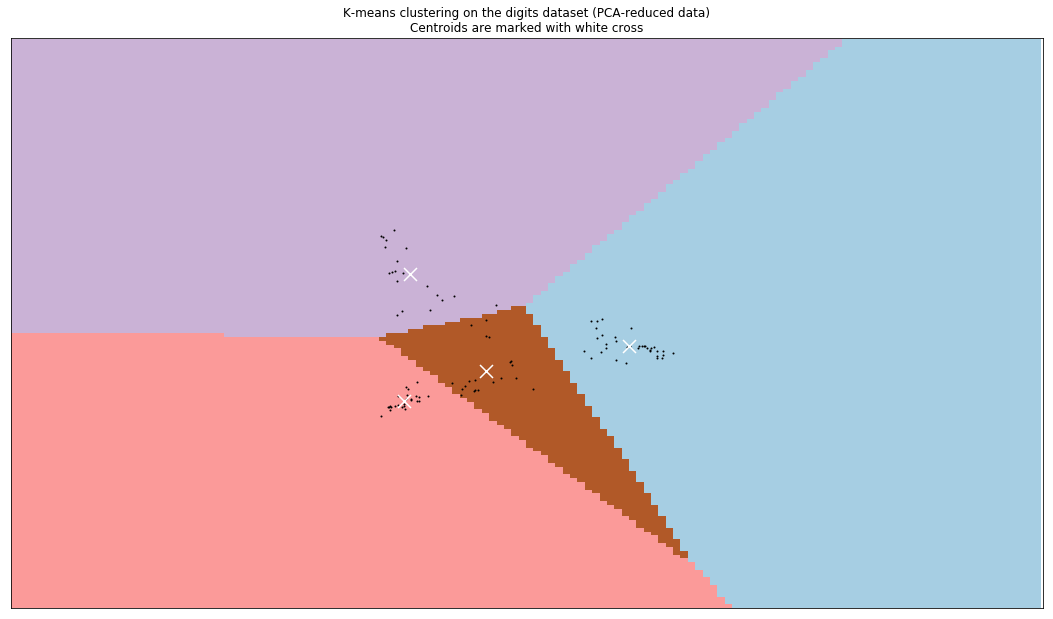

,0,1
0,判决如下:驳回上诉，维持原判。二审案件受理费50元，由张金路负担（已交纳）。本判决为终审判决。,0
1,判决如下:一、被告人夏天虎犯故意伤害罪，判处有期徒刑十个月，缓刑一年。第 4 页夏天虎故意伤...,3
2,判决如下:驳回上诉，维持原判。第 3 页聂巧连、高德珍生命权、健康权、身体权纠纷二审民事判决...,0
3,判决如下:一、被告人李正成犯故意伤害罪，判处有期徒刑一年，缓刑二年（缓刑考验期自判决执行之日...,3
4,判决如下:一、被告人胡某3犯故意伤害罪，判处有期徒刑一年，缓刑一年零六个月。（缓刑考验期限自...,3
5,判决如下:一、被告薛建广于本判决生效后10日内赔偿原告张海宝各项损失594228元；二、驳回...,0
6,判决如下:一、被告人张春良犯故意伤害罪，判处有期徒刑七个月。（刑期自判决执行之日起计算，判决...,3
7,判决如下:被告人何某甲犯故意伤害罪，判处有期徒刑一年零九个月，缓刑二年。（缓刑考验期限，从判...,2
8,判决如下:一、被告人王铁柱犯故意伤害罪，判处有期徒刑十年。（刑期从判决执行之日起计算。判决执...,2
9,判决如下:被告人尹代超犯故意伤害罪，判处有期徒刑六个月，缓刑十个月。（缓刑考验期从判决确定之...,2


In [93]:
## tf-idf建模后K-means聚类
def clean(single_para,stopwords_clean):
    """
    将stopwords和每一段文本取差集，清洗数据
    param single_para:没清洗文本集中的每一段数据
    return list_clean:每一段清洗好的文本
    """
    list_clean = set(single_para).difference(set(stopwords_clean))
    return list_clean

def data_prepare(text_list):
    """
    把数据清理干净
    param text_list:没清洗过的文本列表
    return list_clean:清洗过的文本列表
    """
    table_segments_list = list(map(lambda x:jieba.lcut(x),text_list))
    stopwords = list(map(lambda x:x.strip("\n"),codecs.open('stopwords.txt', 'r', 'utf-8').readlines()))
    stopwords_clean = list(map(lambda x:x.strip("\r"),stopwords))
    list_clean = list(map(clean,table_segments_list,stopwords_clean))
    return list_clean

def tf_idf_scikit(words):
    """
    使用scikit-learn建立tf-idf模型
    param words:清洗过的文本列表
    return tf-idf:tf-idf词袋模型
    """
    # 将文本中的词语转换为词频矩阵 矩阵元素a[i][j] 表示j词在i类文本下的词频
    vectorizer = CountVectorizer()

    # 统计每个词语的tf-idf权值
    transformer = TfidfTransformer()

    # 第一个fit_transform是计算tf-idf 第二个fit_transform是将文本转为词频矩阵
    tfidf = transformer.fit_transform(vectorizer.fit_transform(words))

    # 获取词袋模型中的所有词语
    word = vectorizer.get_feature_names()

    # 将tf-idf矩阵抽取出来，元素w[i][j]表示j词在i类文本中的tf-idf权重
    weight = tfidf.toarray()
    return weight

def classifier(weight,clusters_num):
    """
    使用
    param weight:tf-idf的权重
    param clusters_num:分类簇心数量
    return list_classification:文本与分类结果列表
    """
    list_classification = []
    ## 设计随机种子
    random_status = random.randint(1,1000)

    ## 建立Kmeans分类器
    clf = KMeans(init='k-means++',n_clusters = clusters_num,random_state = random_status,n_init=10)

    ## PCA降维处理
    reduced_data = pca(weight)

    ## 训练
    s = clf.fit(reduced_data)
    
    ## 参数显示
    # print(np.shape(clf.cluster_centers_)) #簇心
    print("标签数量",clf.labels_) 
    print("簇心之间的平均欧氏距离",clf.inertia_) #簇心之间的欧氏距离

    ## 文章归类处理
    i = 1
    while i <= len(clf.labels_):
        list_classification.append(clf.labels_[i-1])
        i = i + 1
    return list_classification,clf

def pca(weights):
    reduced_data = PCA(n_components=2).fit_transform(weights)
    return reduced_data

def ploting(reduced_data,clf): 
    
    h = .02
    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

    # Plot the centroids as a white X
    centroids = clf.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

## 得到判决表
def data_input(table):
    """
    引入文本材料
    Param table:目标列表
    return table_judgements:含有目标文本的list
    """
    table_judgements = table["法院判决"].dropna()
    return table_judgements

table_judgements = data_input(table_final_2)

## 使用一百篇篇文章来做测试
data_test = data_prepare(list(table_judgements))[0:100] 

## 单词列表组成字符串
words = list(map(lambda x:" ".join(list(x)),data_test))

## tf-idf转换weight
weight = tf_idf_scikit(words)

## 分类器得到分类
list_classification,clf = classifier(weight,4)

## pca降维
reduced_data = pca(weight)

## 将分类情况可视化
ploting(reduced_data,clf)

## 将分类结果形成列表
pd.DataFrame([list(table_judgements[0:100]),list_classification]).T

### 使用神经网络分类（RNN，初步分类）
* 该方法只适用于判断某一类文本
* 回答如“是否该文本里，法院支不支持正当防卫”诸如此类的问题
* 但这个方法需要使用大量人工标注的文本，因此需要等大家做完很多题目以后，进行神经网络训练

In [ ]:
import pickle
import os
os.chdir("正当防卫的1000份文书")
with open("corpus.pickle", 'rb') as f:
    corpus = pickle.load(f)
table_final_2 = pd.read_excel("final_table_2.xlsx")

In [ ]:
import pandas as pd
import numpy as np
import gensim
from gensim.models import word2vec
import re
import os
import tensorflow as tf

In [ ]:
os.path.abspath(".")
os.chdir("word2vec-nlp-tutorial")
data_t = pd.read_csv("labeledTrainData.tsv",sep = "\t")
del data_t["id"]

In [ ]:
## 训练word_vec模型
if not os.path.exists("mymodel"):
    if not os.path.exists("imdb_text"):
        data_un = pd.read_csv("unlabeledTrainData.tsv",
                             headers = 0,
                             delimiter = "\t",
                             quoting = 3)
        pat = re.compile(r"[A-Za-z]+|[!?,:().]")
        with open("imdb_text","a",encoding = "utf-8") as f:
            for rev in data_un.review:
                str_list = pat.findall(rev)
                str_list = [x.lower() for x in str_list]
                string = " ".join(str_list)
                f.write(string + "\n")
            del data_un
    sentences = word2vec.Text8Corpus("imdb_text")
    model = word2vec.Word2Vec(sentences,size = 50)
    
    # 训练skip-gram模型，默认window = 5
    model.save("mymodel")
else:
    model = word2vec.Word2Vec.load("mymodel")

In [ ]:
word_vectors = model.wv
del model
data_t["vec"] = data_t.review.apply(lambda x:[word_vectors[w] for w in x.split() if w in word_vectors])

In [ ]:
np.shape(data_t.head().vec[0])
del data_t['review']
del word_vectors

In [ ]:
import gc
gc.collect()

In [ ]:
data_t = data_t[data_t["vec"].apply(lambda x:len(x) > 0)]
data_t.sentiment.value_counts()
maxlength = max([len(x) for x in data_t.vec])
maxlength
# 评价为1，正面的12499
# 负面为0，负面的12495
# 有几个没有被训练出词向量

In [ ]:
sum(data_t.vec.apply(len) > 300)
## 填充评论长度
def pad(x):
    if len(x) > 300:
        x1 = x[:300] # 超过300的，截取0：300的
    else:
        x1 = np.zeros((300,50))
        x1[:len(x)] = x # 不满300的，就直接填充0
    return x1

In [ ]:
data_t["vec"] = data_t.vec.apply(pad)
data_t.vec.head()[0]
np.shape(data_t.sentiment.values)

In [ ]:
### RNN部分
import tensorflow as tf
learning_rate = 0.002
batch_size = 100
n_input = 50
n_steps = 300
n_hidden = 300
n_classes = 2

# RNN的输入维度，为3个维度，第一维度为输入的批次
# 第二维度为输入step，word-vector的长度，或者说文本的顺序
# 第三维度为输入单词向量，每个单词以50个向量来表示
# [批次,step,input]

In [ ]:
x = tf.placeholder(tf.float32,[None,n_steps,n_input])
y = tf.placeholder(tf.int64,[None])
keep_prob = tf.placeholder("float")

In [ ]:
def length(shuru):
    return tf.reduce_sum(tf.sign(tf.reduce_max(tf.abs(shuru),reduction_indices = 2)),reduction_indices = 1)
# 找出真正长度

In [ ]:
cell = tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.GRUCell(n_hidden,
                                    kernel_initializer = tf.truncated_normal_initializer(stddev = 0.0001),
                                    bias_initializer = tf.truncated_normal_initializer(stddev = 0.0001)),
                                    output_keep_prob = keep_prob)

In [ ]:
output,_ = tf.nn.dynamic_rnn(
           cell,
           x,
           dtype = tf.float32,
           sequence_length = length(x))

In [ ]:
output.get_shape()
index = tf.range(0,batch_size) * n_steps + (tf.cast(length(x),tf.int32) - 1)
flat = tf.reshape(output,[-1,int(output.get_shape()[2])])
last = tf.gather(flat,index)

In [ ]:
weight = tf.Variable(tf.truncated_normal((n_hidden,n_classes),stddev = 0.001))
bias = tf.Variable(tf.constant(0.1,shape = [n_classes]))
com_out = tf.matmul(last,weight) + bias
prediction = tf.nn.softmax(com_out) ## 用来计算准确率

In [ ]:
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y,logits = com_out))

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate)
grads = optimizer.compute_gradients(cross_entropy) # 梯度裁剪
for i,(g,v) in enumerate(grads):
    if g is not None:
        grads[i] = (tf.clip_by_norm(g,5),v)
train_op = optimizer.apply_gradients(grads)

In [ ]:
correct_pred = tf.equal(tf.argmax(prediction,1),y)
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

In [ ]:
### 产生批次
def generatebatch(X,Y,n_examples,batch_size):
    for batch_i in range(n_examples // batch_size):
        start = batch_i * batch_size
        end = start + batch_size
        batch_xs = X[start:end]
        batch_ys = Y[start:end]
        yield batch_xs,batch_ys

In [ ]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
saver = tf.train.Saver()

In [ ]:
ii = 0
for step in range(10):
    index = np.random.permutation(int(len(data_t.vec.values)))
    for batch_x,batch_y in generatebatch(data_t.vec.values[index],data_t.sentiment.values[index],len(data_t.vec.values),batch_size):
        batch_x = np.concatenate(batch_x).reshape(batch_size,300,50)
        batch_x.astype(np.float64)
        sess.run(train_op,feed_dict = {x:batch_x,y:batch_y,keep_prob:0.5})
        loss = sess.run(cross_entropy,feed_dict = {x:batch_x,y:batch_y,keep_prob:1})
        print(loss)
    acc = sess.run(accuracy,feed_dict = {x:batch_x,y:batch_y,keep_prob:1})
    loss = sess.run(cross_entropy,feed_dict = {x:batch_x,y:batch_y,keep_prob:1})
    #saver.save(sess,'./teansorflow',global_step = step)
    print("Iter " + str(step) + ",Minibatch Loss= ".format(loss) + "{}".format(acc))
print("Optimization Finished")